# Osalausete struktuuri visualiseerimine lause uid järgi

## Funktsioonid

In [1]:
import networkx as nx
import sys
sys.path.append('../../syntax_experiments/syntax_cutter_library')
from syntaxCutter.sentence import sentence

def eprint(*args, **kwargs):
    print(*args, file=sys.stderr, **kwargs)

def tree(gClause, key):
    kids = []
    for child in gClause.successors(key):
        kids.append(tree(gClause, child))
    if not len(kids):
        return gClause.nodes[key]['deprel']
    return {gClause.nodes[key]['deprel']: sorted(kids, key=lambda x: str(x).replace('\'','').replace('{',''))}

def makeGraphFromStructure(data, G=None, parent=None):
    if not G:
        G = nx.DiGraph()
        
    for b in data:
        nodeNr = len(G.nodes) + 1
        if type(b)==str:
            G.add_node(nodeNr, deprel=b)
            if parent:
                G.add_edge(parent,nodeNr)
        else:
            key = node=list(b.keys())[0]
            G.add_node(nodeNr, deprel=key )
            if parent:
                G.add_edge(parent,nodeNr)
            G = makeGraphFromStructure(b[key], G, nodeNr)
            
    return G

#for drawing
import matplotlib.pyplot as plt
from textwrap import wrap
from networkx.drawing.nx_agraph import graphviz_layout

def drawStructureGraph(G, **kwargs):
    title = None
    pos = graphviz_layout(G, prog='dot')
    if 'title' in kwargs:
        title = kwargs['title']
    
    if 'color' in kwargs:
        color = kwargs['color']
    else:
        color = 'lightskyblue'
    #pealkiri
    colors = [color for node in G.nodes]
    if title:
        title = ("\n".join(wrap( title, 120)))
        plt.title(title)
    # joonise suurus, et enamik puudest ära mahuks
    plt.rcParams["figure.figsize"] = (18.5, 10.5)
    labels = dict([(node, G.nodes[node]['deprel'], ) for node in sorted([node for node in G.nodes]) if node])
    nx.draw(G,pos, with_labels=True, labels=labels, node_color=colors)
    plt.show()
    plt.clf()


    
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import matplotlib.pyplot as plt

 
def drawtrees(UID):
    global collection
    cmap = plt.cm.Set3
    colID=int(UID.split('_')[0])
    sentenceStart=int(UID.split('_')[1])
    print(f'colID :{colID}   sentenceS:{sentenceStart}')
    G = None
    ###
    rows = []
    current_clauses = []


    q = IndexQuery( [colID] )# & LayerQuery('v168_stanza_ensemble_syntax', lemma='Sven')

    for (colId, text) in collection.select ( query=q,  progressbar='notebook', layers=['v166_sentences', 'v169_clauses', 'v168_stanza_ensemble_syntax'], return_index=True ):
        print (text.meta)
        sentences_start = [span.start for span in text.v166_sentences]
        sentences_end = [span.end for span in text.v166_sentences]
        clauses_refs = {}

        if not sentenceStart in sentences_start: 
            eprint (f'Not found sentence with span.start {sentenceStart}') 
            return

        for clause in text.v169_clauses:
            for word in clause:
                clauses_refs[word.start] = clause.start

        for span in text.v168_stanza_ensemble_syntax:
            if span.start < sentenceStart: continue
            if span.start == sentenceStart:
                current_sentence = []
                current_clauses = []
                G = sentence.Sentence()

            if clauses_refs[span.start] not in current_clauses:
                current_clauses.append(clauses_refs[span.start])


            clauseNr = current_clauses.index(clauses_refs[span.start]) + 1

            G.add_node(span.id, id=span.id, lemma=span.lemma, form=span.text.replace('\n',''), pos=span.upostag, deprel=span.deprel, feats='|||'.join(span.feats.keys()), clause=clauseNr)
            print (G.nodes[span.id])
            G.add_edge(span.head, span.id, deprel = span.deprel)
            #rows.append([str(x) for x in [colId, span.start, span.id, span.text.replace('\n',''), span.lemma, span.upostag, span.deprel, span.head , '||'.join(span.feats.keys()) , clauseNr,]] )



            if span.end in sentences_end:
                break
    
    if G:
        #colors
        node_colors = [cmap(G.nodes[node]['clause']) if node else 'lightskyblue' for node in G]
        
        #draw Sentence
        G.drawGraph(custom_colors=node_colors, title=G.text())

        #draw Clauses
        for (i, gClause) in enumerate(G.get_clauses()):
            #print (gClause.text())
            clauseLength = gClause.tokensTotal()

            forest = []

            #print('\tClause\t', gClause.get_prop('form'))
            deprels = nx.get_node_attributes(gClause, 'deprel').items()
            nodes = {}
            for k, v in deprels:
                nodes[k] = v
            #
            print()
            for key, value in  sorted(nodes.items(), key=lambda x:x[1]):
                if not nx.ancestors(gClause, key):
                    forest.append(tree(gClause, key))
            forestG = makeGraphFromStructure(forest)
            drawStructureGraph(forestG, title=gClause.text() + " ", color=cmap(i+1))
            print(str(forest))
    return 
  

## Ühenduse loomine andmebaasiga

In [2]:
#connect to DB
from estnltk.storage.postgres import PostgresStorage, IndexQuery, LayerQuery
storage = PostgresStorage(pgpass_file='~/.pgpass',
                          schema='estonian_text_corpora',
                          role='estonian_text_corpora_read',
                          temporary=False)



#collectionName = 'koondkorpus_base_v2'
collectionName = 'koondkorpus_base_subset_of_5000_v2'

collection = storage[collectionName]

INFO:storage.py:42: connecting to host: 'postgres.keeleressursid.ee', port: '5432', dbname: 'estonian-text-corpora', user: 'zummy'
INFO:storage.py:58: schema: 'estonian_text_corpora', temporary: False, role: 'estonian_text_corpora_read'


## Joonistamine lause uid järgi

colID :3572   sentenceS:215


{'file': 'aja_sloleht_1998_04_30.xml', 'type': 'artikkel', 'title': 'Politsei uurib riigikantselei korteritehinguid', 'rubriik': '', 'subcorpus': 'aja_sloleht', 'alamrubriik': '', 'ajalehenumber': 'SL Öhtuleht 1998.04.30'}
{'id': 1, 'lemma': '"', 'form': '"', 'pos': 'Z', 'deprel': 'punct', 'feats': '', 'clause': 1}
{'id': 2, 'lemma': 'kontroll', 'form': 'Kontrolli', 'pos': 'S', 'deprel': 'nmod', 'feats': 'sg|||com|||gen', 'clause': 1}
{'id': 3, 'lemma': 'materjal', 'form': 'materjalid', 'pos': 'S', 'deprel': 'nsubj', 'feats': 'pl|||com|||nom', 'clause': 1}
{'id': 4, 'lemma': 'andma', 'form': 'annavad', 'pos': 'V', 'deprel': 'root', 'feats': 'af|||pl|||ps|||mod|||ps3|||pres|||indic', 'clause': 1}
{'id': 5, 'lemma': 'alune', 'form': 'alust', 'pos': 'S', 'deprel': 'obj', 'feats': 'sg|||com|||part', 'clause': 1}
{'id': 6, 'lemma': 'arvama', 'form': 'arvata', 'pos': 'V', 'deprel': 'acl', 'feats': 'inf|||mod', 'clause': 1}
{'id': 7, 'lemma': ',', 'form': ',', 'pos': 'Z', 'deprel': 'punct', '

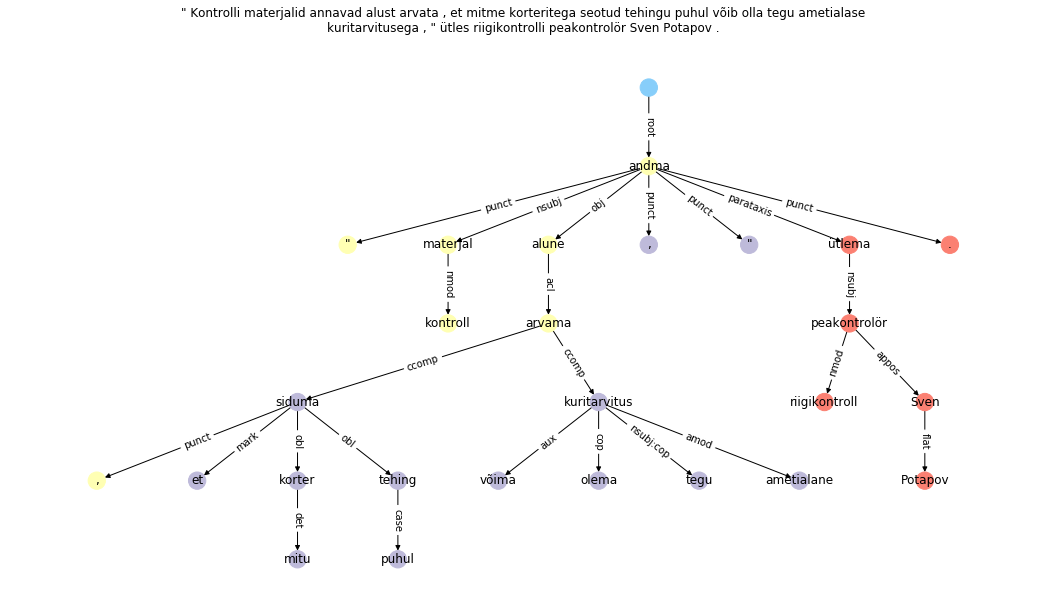

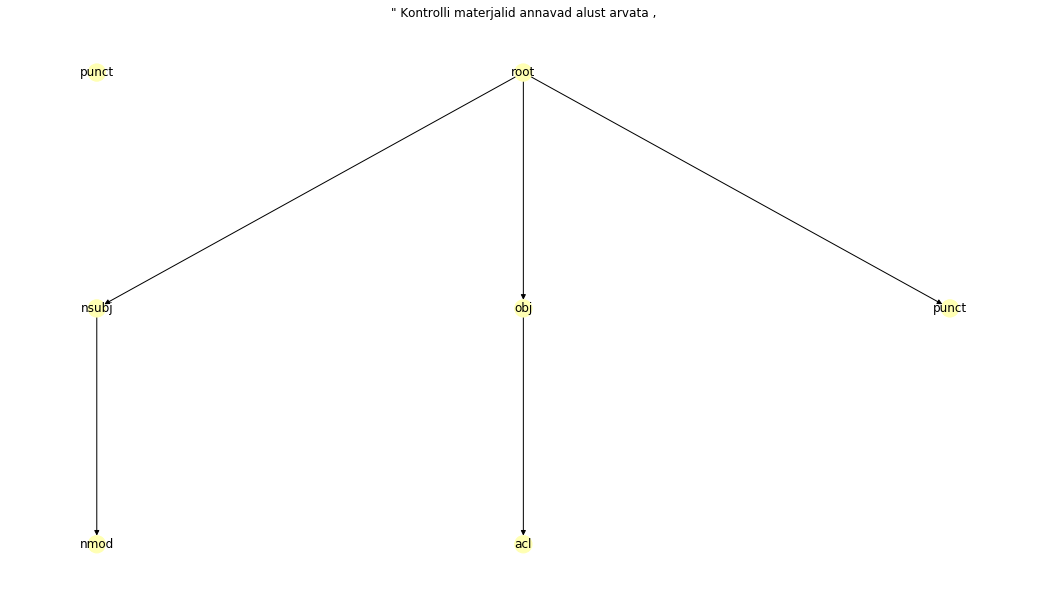

['punct', {'root': [{'nsubj': ['nmod']}, {'obj': ['acl']}, 'punct']}]



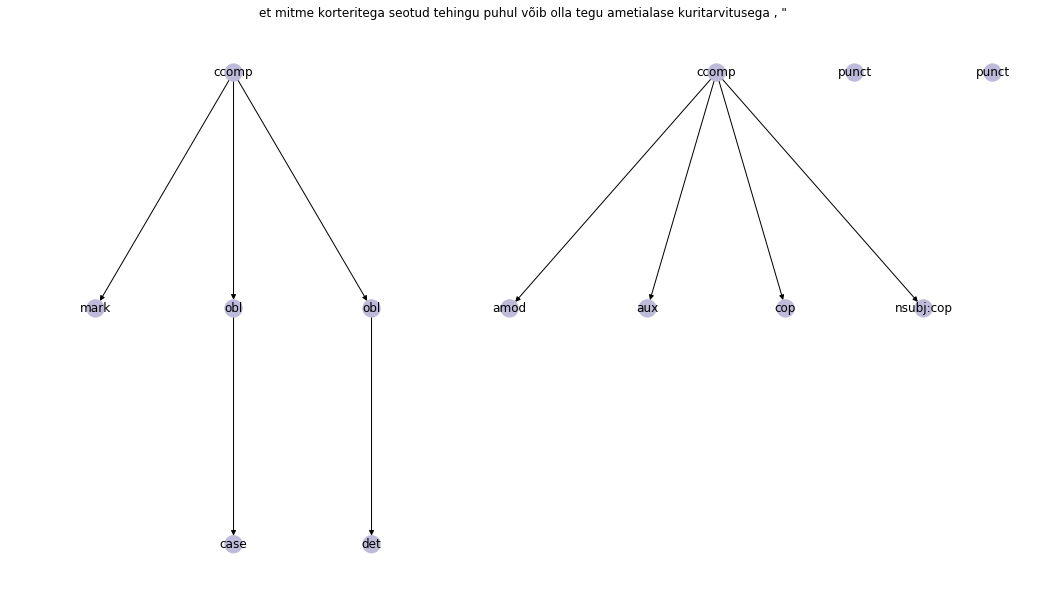

[{'ccomp': ['mark', {'obl': ['case']}, {'obl': ['det']}]}, {'ccomp': ['amod', 'aux', 'cop', 'nsubj:cop']}, 'punct', 'punct']



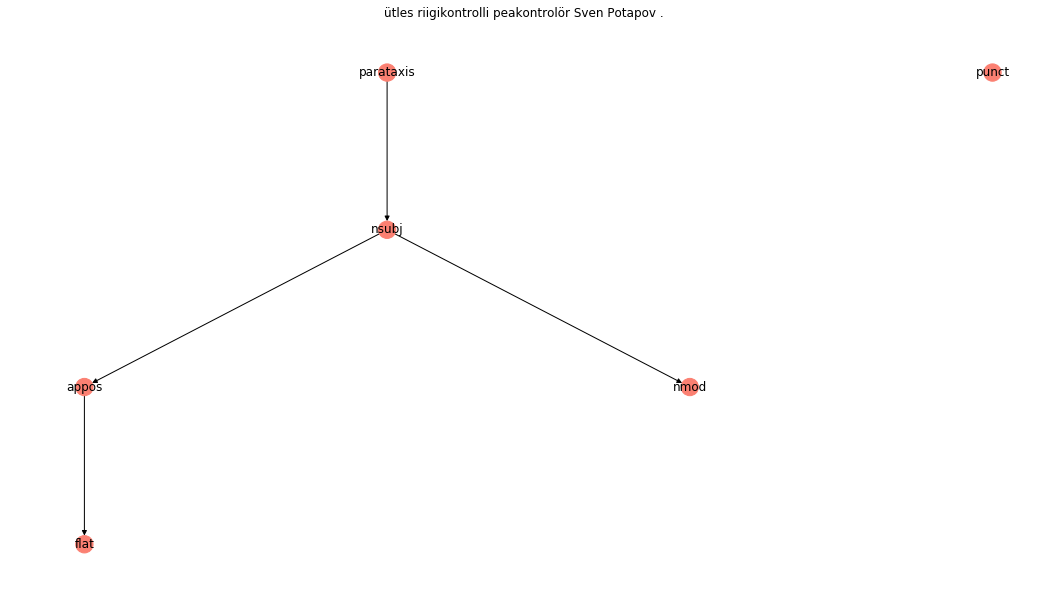

[{'parataxis': [{'nsubj': [{'appos': ['flat']}, 'nmod']}]}, 'punct']


<Figure size 1332x756 with 0 Axes>

In [3]:
drawtrees('3572_215_3')

colID :3572   sentenceS:215


{'file': 'aja_sloleht_1998_04_30.xml', 'type': 'artikkel', 'title': 'Politsei uurib riigikantselei korteritehinguid', 'rubriik': '', 'subcorpus': 'aja_sloleht', 'alamrubriik': '', 'ajalehenumber': 'SL Öhtuleht 1998.04.30'}
{'id': 1, 'lemma': '"', 'form': '"', 'pos': 'Z', 'deprel': 'punct', 'feats': '', 'clause': 1}
{'id': 2, 'lemma': 'kontroll', 'form': 'Kontrolli', 'pos': 'S', 'deprel': 'nmod', 'feats': 'sg|||com|||gen', 'clause': 1}
{'id': 3, 'lemma': 'materjal', 'form': 'materjalid', 'pos': 'S', 'deprel': 'nsubj', 'feats': 'pl|||com|||nom', 'clause': 1}
{'id': 4, 'lemma': 'andma', 'form': 'annavad', 'pos': 'V', 'deprel': 'root', 'feats': 'af|||pl|||ps|||mod|||ps3|||pres|||indic', 'clause': 1}
{'id': 5, 'lemma': 'alune', 'form': 'alust', 'pos': 'S', 'deprel': 'obj', 'feats': 'sg|||com|||part', 'clause': 1}
{'id': 6, 'lemma': 'arvama', 'form': 'arvata', 'pos': 'V', 'deprel': 'acl', 'feats': 'inf|||mod', 'clause': 1}
{'id': 7, 'lemma': ',', 'form': ',', 'pos': 'Z', 'deprel': 'punct', '

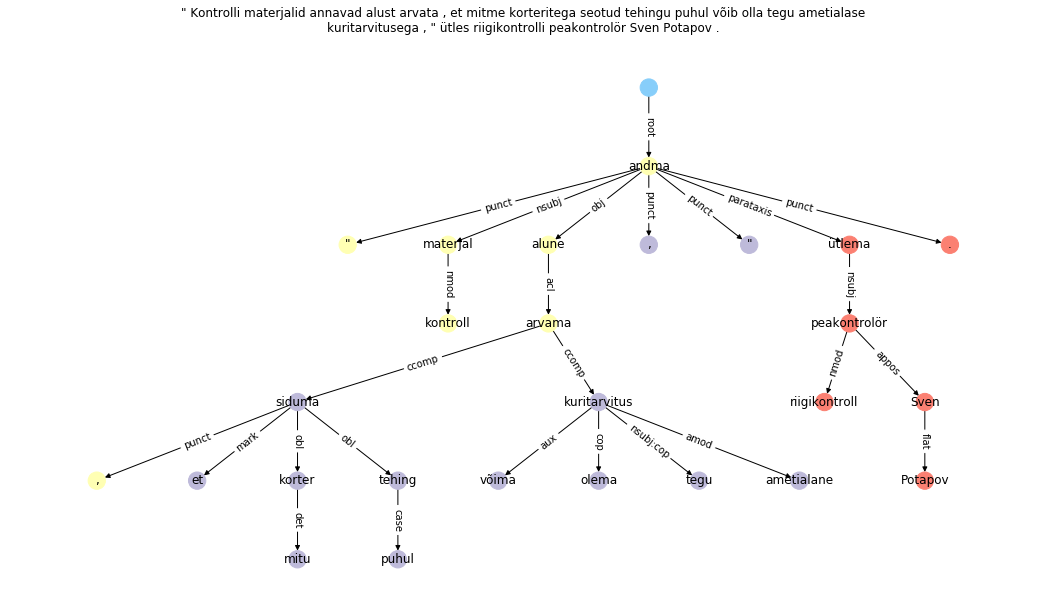

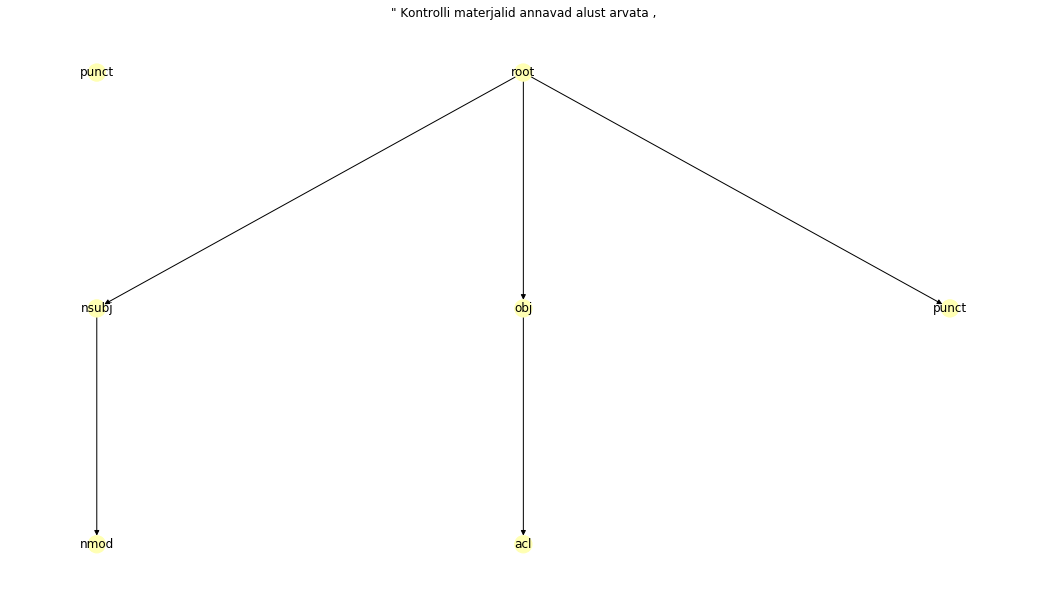

['punct', {'root': [{'nsubj': ['nmod']}, {'obj': ['acl']}, 'punct']}]



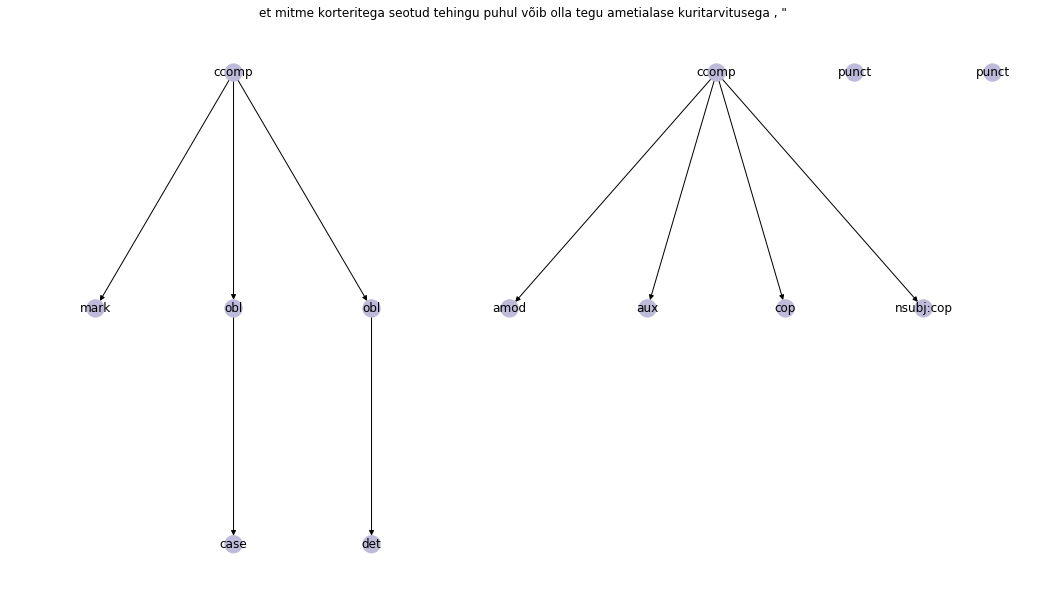

[{'ccomp': ['mark', {'obl': ['case']}, {'obl': ['det']}]}, {'ccomp': ['amod', 'aux', 'cop', 'nsubj:cop']}, 'punct', 'punct']



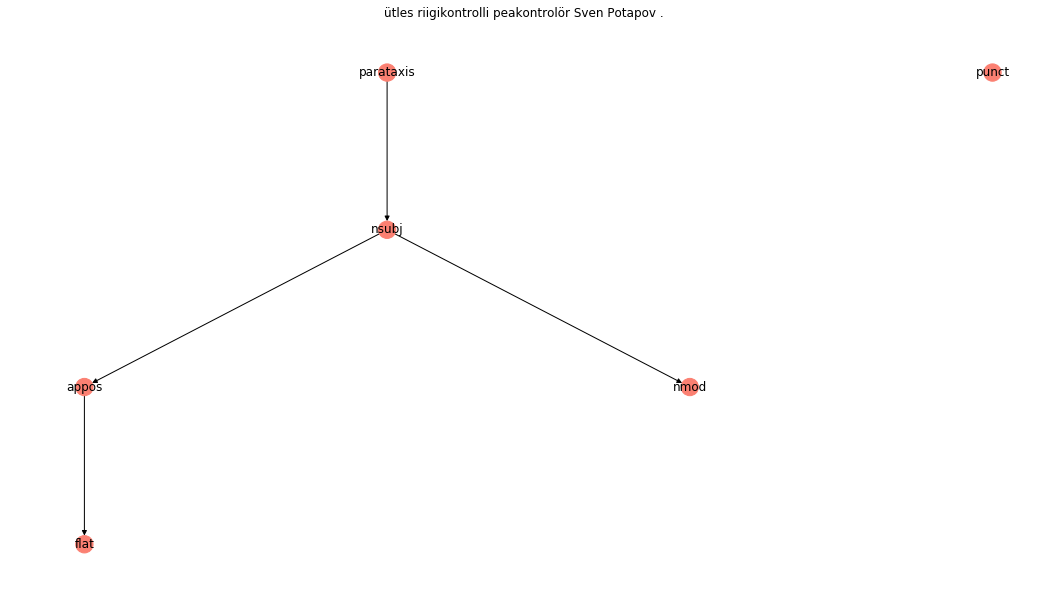

[{'parataxis': [{'nsubj': [{'appos': ['flat']}, 'nmod']}]}, 'punct']


<Figure size 1332x756 with 0 Axes>

In [4]:
drawtrees('3572_215_3')

colID :4223   sentenceS:261


{'file': 'aja_sloleht_1999_04_05.xml', 'type': 'artikkel', 'title': 'Sedapuhku kõrbes Russell Hoult', 'author': 'INDREK PETERSOO', 'rubriik': '', 'subcorpus': 'aja_sloleht', 'alamrubriik': '', 'ajalehenumber': 'SL Öhtuleht 1999.04.05'}
{'id': 1, 'lemma': 'Derby', 'form': 'Derby', 'pos': 'S', 'deprel': 'nsubj', 'feats': 'sg|||nom|||prop', 'clause': 1}
{'id': 2, 'lemma': 'pääsema', 'form': 'pääses', 'pos': 'V', 'deprel': 'root', 'feats': 'af|||ps|||sg|||aux|||ps3|||impf|||indic', 'clause': 1}
{'id': 3, 'lemma': 'küll', 'form': 'küll', 'pos': 'D', 'deprel': 'advmod', 'feats': '', 'clause': 1}
{'id': 4, 'lemma': 'Deon', 'form': 'Deon', 'pos': 'S', 'deprel': 'nmod', 'feats': 'sg|||nom|||prop', 'clause': 1}
{'id': 5, 'lemma': 'Burtoni', 'form': 'Burtoni', 'pos': 'S', 'deprel': 'flat', 'feats': 'sg|||gen|||prop', 'clause': 1}
{'id': 6, 'lemma': 'täpne', 'form': 'täpse', 'pos': 'A', 'deprel': 'amod', 'feats': 'sg|||gen|||pos', 'clause': 1}
{'id': 7, 'lemma': 'käärlöök', 'form': 'käärlöögi', 'p

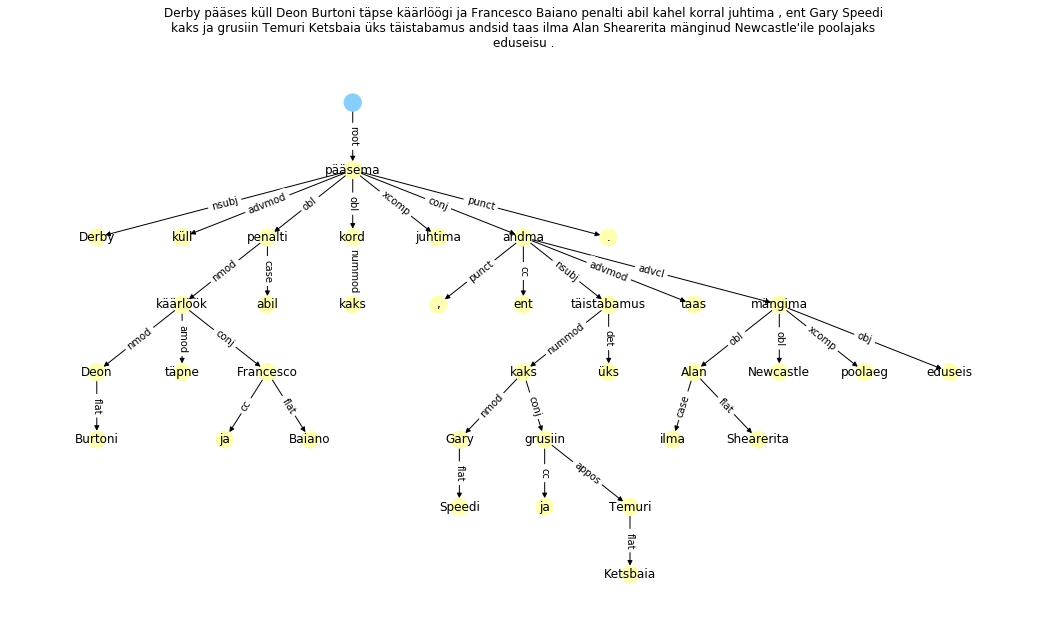

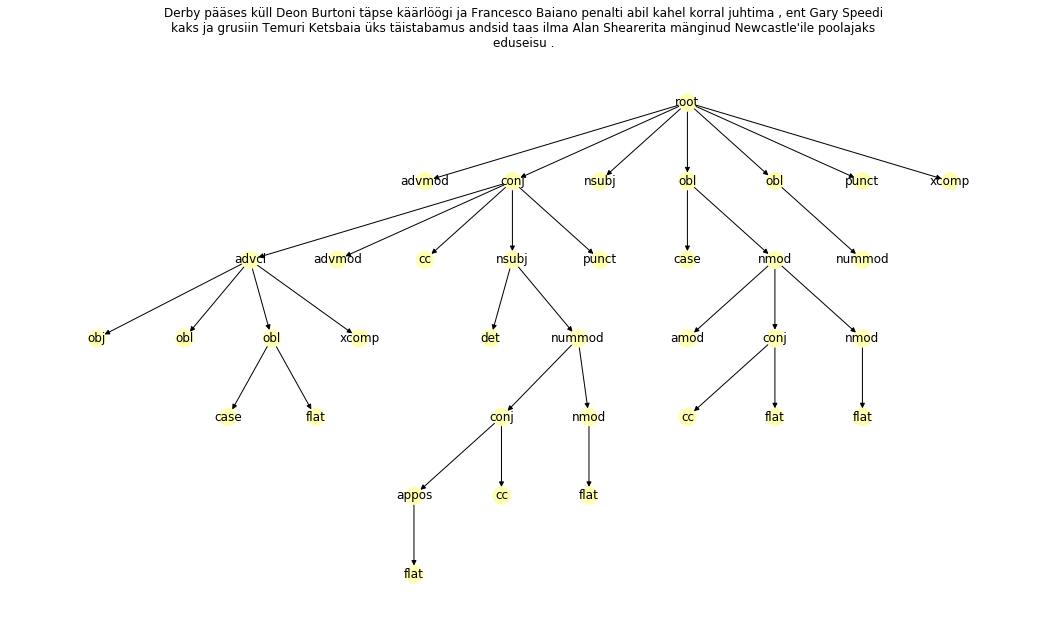

[{'root': ['advmod', {'conj': [{'advcl': ['obj', 'obl', {'obl': ['case', 'flat']}, 'xcomp']}, 'advmod', 'cc', {'nsubj': ['det', {'nummod': [{'conj': [{'appos': ['flat']}, 'cc']}, {'nmod': ['flat']}]}]}, 'punct']}, 'nsubj', {'obl': ['case', {'nmod': ['amod', {'conj': ['cc', 'flat']}, {'nmod': ['flat']}]}]}, {'obl': ['nummod']}, 'punct', 'xcomp']}]


<Figure size 1332x756 with 0 Axes>

In [5]:
drawtrees('4223_261_4')